# Import libraries and read csv

In [2]:
import re
import networkx as nx
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [3]:
hero_netw = pd.read_csv('./hero-network.csv')
edges = pd.read_csv('./edges.csv')
nodes = pd.read_csv('./nodes.csv')

# Data Preprocessing

**As always, in the data science area, you can find some inconsistencies in the provided data. Therefore, some modifications should be made to the data to make it consistent across all of the datasets you have. To ensure consistency in the data, keep the following in mind:**
- Some of the heroes' names in 'hero-network.csv' are not found in 'edges.csv'. This inconsistency exists for the following reasons:
- Some heroes' names in 'hero-netowrk.csv' have extra spaces at the end of their names compared to their names in 'edges.csv'.
- Some heroes' names in 'hero-netowrk.csv' have an extra '/' at the end of their names compared to their names in 'edges.csv'.
- The hero name 'SPIDER-MAN/PETER PARKER' in 'edges.csv' has been changed to 'SPIDER-MAN/PETER PAR' in 'hero-network.csv' due to a string length limit in 'hero-network.csv'.

- Some entries in the 'hero-network.csv' have the same hero in both columns. In the graph, these entries form a self-loop. Because a self-loop makes no sense in this network, you can safely remove those from the dataset.


In [4]:
def preprocessing(df):
    """
    Trim whitespace, replace backspace from ends of each value across all series in dataframe, fix hero name and remove
    duplicates
    """
    replace_backspace = lambda x: re.sub(r'/$', '', x)
    trim_strings = lambda x: x.strip()
    df = df.applymap(replace_backspace).applymap(trim_strings)
    df.drop(df[df['hero1'] == df['hero2']].index, inplace=True)
    replace_name = lambda x: re.sub(r'PETER PAR$', 'PETER PARKER', x)
    return df.applymap(replace_name)

In [5]:
hero_netw = preprocessing(hero_netw)
hero_netw

,hero1,hero2
0,"LITTLE, ABNER",PRINCESS ZANDA
1,"LITTLE, ABNER",BLACK PANTHER/T'CHAL
2,BLACK PANTHER/T'CHAL,PRINCESS ZANDA
3,"LITTLE, ABNER",PRINCESS ZANDA
4,"LITTLE, ABNER",BLACK PANTHER/T'CHAL
...,...,...
574462,COLOSSUS II/PETER RA,CALLISTO
574463,CALLISTO,ROGUE
574464,CALLISTO,CALIBAN
574465,CALIBAN,ROGUE


# Graphs setup

**For this homework, we are going to build two different graphs:**

- First graph: Will be constructed using the data stored in the 'hero-network.csv' file, in which an edge between two heroes can be found if they have appeared in the same comic together. The number of edges between two heroes represents the number of times they have collaborated in different comics. The graph should be considered weighted and undirected. It is up to you to decide which metric to use to calculate the weights, but we anticipate that the cost will be lower for heroes with more collaborations. Please specify which metric you used to select the weights in the report.

- Second graph: The data in 'nodes.csv' and 'edges.csv' will be used to construct the second graph. The type of node (hero/comic) can be found in 'nodes.csv', and an edge between a hero node and a comic node can be found in 'edges.csv' when the hero has appeared in that specific comic. This graph is assumed to be undirected and unweighted.

In [6]:
# calculate number of collaborations between each pair of heroes
weights = hero_netw.groupby(hero_netw.columns.tolist()).size().reset_index().rename(columns={0: 'weight'})
weights

,hero1,hero2,weight
0,24-HOUR MAN/EMMANUEL,"FROST, CARMILLA",1
1,24-HOUR MAN/EMMANUEL,KILLRAVEN/JONATHAN R,1
2,24-HOUR MAN/EMMANUEL,M'SHULLA,1
3,3-D MAN/CHARLES CHAN,ANGEL/WARREN KENNETH,1
4,3-D MAN/CHARLES CHAN,ANT-MAN II/SCOTT HAR,1
...,...,...,...
224094,ZZZAX,"RODRIGUEZ, DEBRA",1
224095,ZZZAX,"ROSS, GEN. THADDEUS",2
224096,ZZZAX,"SUMMERS, NATHAN CHRI",1
224097,ZZZAX,TIGRA/GREER NELSON,1


In [7]:
# some pairs in the dataframe are inverted. They must be merged together in order to avoid cycles in the final graph
weights[['hero1','hero2']] = pd.DataFrame(np.sort(weights[['hero1', 'hero2']].values, axis=1))
hero_netw_weighted_for_graph = weights.groupby(['hero1', 'hero2']).weight.sum().reset_index()
hero_netw_weighted_for_graph

,hero1,hero2,weight
0,24-HOUR MAN/EMMANUEL,"FROST, CARMILLA",1
1,24-HOUR MAN/EMMANUEL,G'RATH,1
2,24-HOUR MAN/EMMANUEL,KILLRAVEN/JONATHAN R,1
3,24-HOUR MAN/EMMANUEL,M'SHULLA,1
4,24-HOUR MAN/EMMANUEL,OLD SKULL,1
...,...,...,...
167095,ZEFRA,ZON,1
167096,ZEUS,ZIRAN,1
167097,ZEUS,ZURAS,4
167098,ZIRAN,ZON,1


In [8]:
# example after merging the inverted pairs
hero_netw_weighted_for_graph[(hero_netw_weighted_for_graph['hero1']=='LITTLE, ABNER') & (hero_netw_weighted_for_graph['hero2']=='PRINCESS ZANDA')]

,hero1,hero2,weight
122483,"LITTLE, ABNER",PRINCESS ZANDA,8


In [9]:
# perform the inverse of each weight. By doing so, the cost will be lower for heroes with more collaborations.
hero_netw_weighted_for_graph['weight'] = round(1/hero_netw_weighted_for_graph['weight'],1)
hero_netw_weighted_for_graph

,hero1,hero2,weight
0,24-HOUR MAN/EMMANUEL,"FROST, CARMILLA",1.0
1,24-HOUR MAN/EMMANUEL,G'RATH,1.0
2,24-HOUR MAN/EMMANUEL,KILLRAVEN/JONATHAN R,1.0
3,24-HOUR MAN/EMMANUEL,M'SHULLA,1.0
4,24-HOUR MAN/EMMANUEL,OLD SKULL,1.0
...,...,...,...
167095,ZEFRA,ZON,1.0
167096,ZEUS,ZIRAN,1.0
167097,ZEUS,ZURAS,0.2
167098,ZIRAN,ZON,1.0


In [10]:
# generate first weighted, undirected graph and plot it
G1 = nx.from_pandas_edgelist(hero_netw_weighted_for_graph,'hero1','hero2', edge_attr='weight', create_using=nx.MultiGraph())

In [11]:
G1['LITTLE, ABNER']['PRINCESS ZANDA']

AtlasView({0: {'weight': 0.1}})

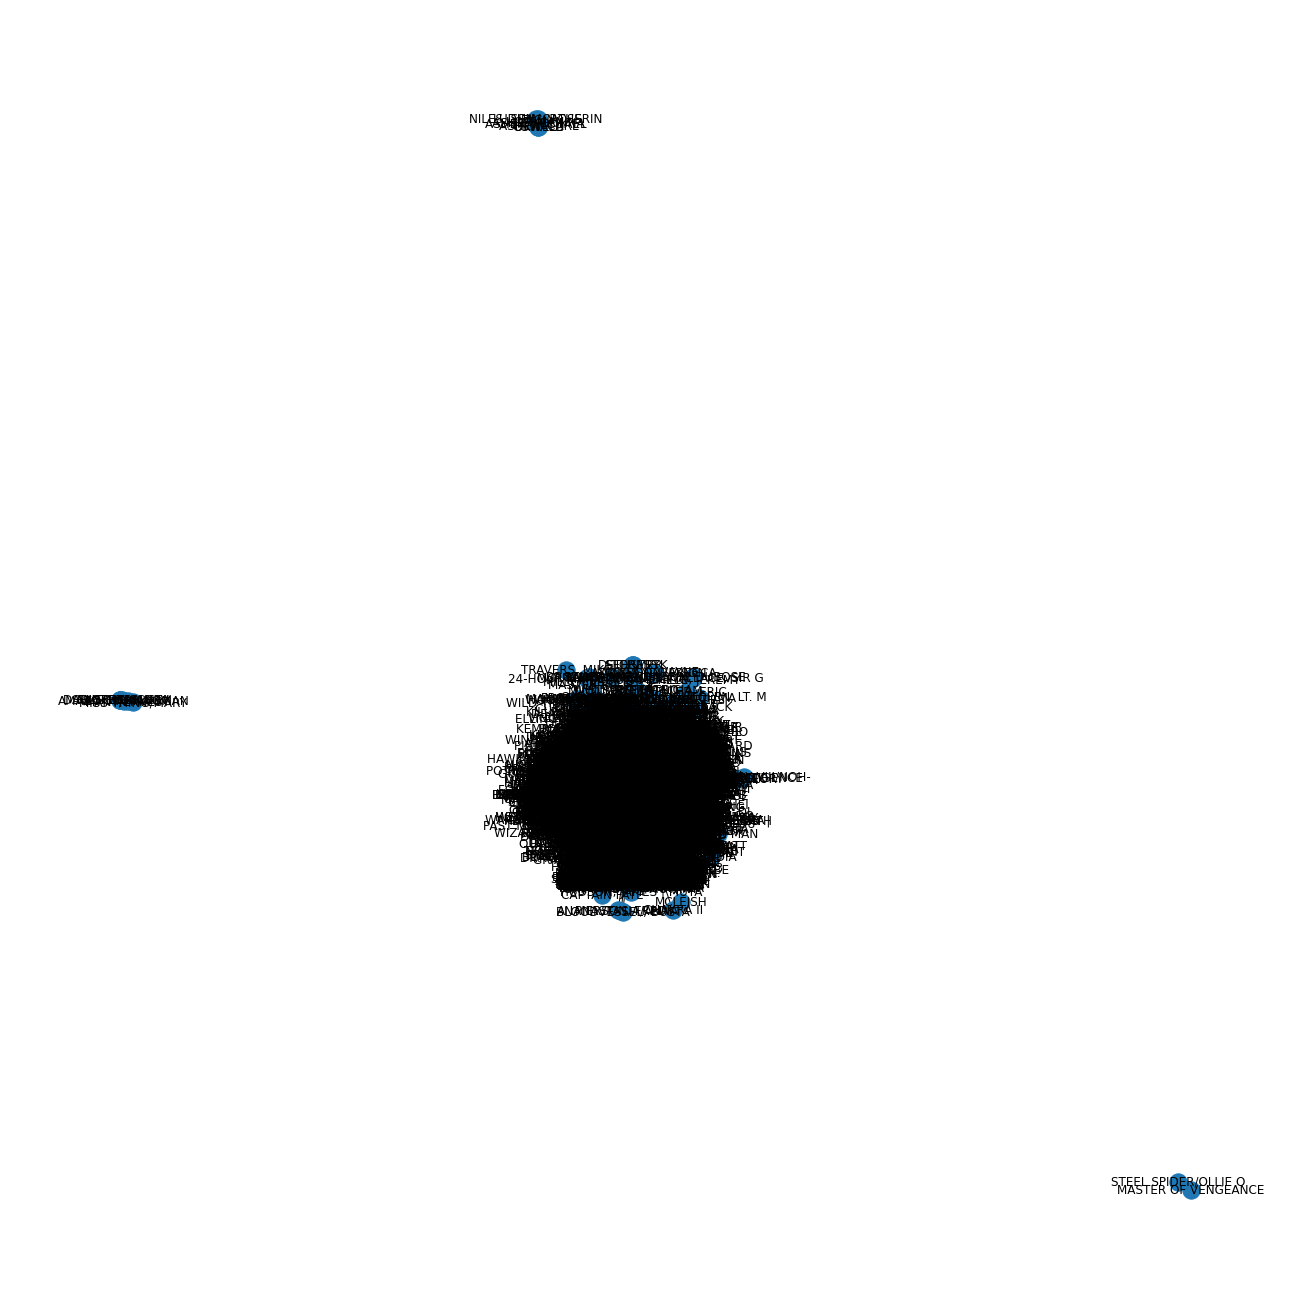

In [61]:
fig = plt.figure(figsize=(18,18))
nx.draw(G1, with_labels=True, node_size=300)
plt.show()

In [12]:
# create second undirected unweighted graph using nodes and edges csv
node_attr = nodes.set_index('node').to_dict('index')

In [13]:
G2 = nx.from_pandas_edgelist(edges, 'hero', 'comic')
nx.set_node_attributes(G2, node_attr)

# 2. Backend Implementation

**The goal of this part is the implementation of a controller system that has different functionalities. The controller should take as input an identifier "i" and run the associated function_i applied to the graph you create from the downloaded data.**

**Definition: As the number of nodes and edges grows, we may request to work on a subset of the data to reduce computation time and improve network visualization. In this case, we will ask you only to consider the data for top N heros. We define the top N heroes as follows:**

   - Top N heroes: The top N heroes who have appeared in the most number of comics. The 'edges.csv' file, which represents the comics in which each hero has appeared, can be used to filter these N heroes.

**Note: When the value of N is not set by the user, the function should consider the whole data.**

# Functionality 1 - extract the graph's features

**Input:**
   - The graph data
   The graph type (ex., number 1 or number 2)
   N: denoting the top N heroes that their data should be considered

**Output:**
   - The number of nodes in the network (if type 2, report for both node types)
   - The number of collaborations of each superhero with the others (only if type 1)
   - The number of heroes that have appeared in each comic (only if type 2)
   - The network's density
   - The network's degree distribution
   - The average degree of the network
   - The network's Hubs (hubs are nodes having degrees more extensive than the 95th percentile of the degree distribution)
   - Whether the Network is sparse or dense

**Note: For this case, it makes sense to differentiate operations between the two graphs: for example, when computing hubs for the second graph, we likely care only about comics.**

In [14]:
# FIND OUTLIERS AND FIX
labels = {}
for n, d in G2.nodes(data=True):
    try:
        l = d["type"]
        labels[l] = labels.get(l, [])
    except KeyError as e:
        print(n)
        continue;

nodes.at[14618, "node"]='SPIDER-MAN/PETER PARKER'

SPIDER-MAN/PETER PARKER


In [16]:
node_attr = nodes.set_index('node').to_dict('index')

In [17]:
G2 = nx.from_pandas_edgelist(edges, 'hero', 'comic')
nx.set_node_attributes(G2, node_attr)

In [15]:
# create a dataframe that gives for each hero its comic appearances. It will be useful to get N nodes from the graph
heroes_appearances = edges.groupby('hero').count().reset_index().rename(columns={'comic':'comic_appearance'}).sort_values(by='comic_appearance', ascending=False).reset_index(drop=True)
heroes_appearances

,hero,comic_appearance
0,SPIDER-MAN/PETER PARKER,1577
1,CAPTAIN AMERICA,1334
2,IRON MAN/TONY STARK,1150
3,THING/BENJAMIN J. GR,963
4,THOR/DR. DONALD BLAK,956
...,...,...
6434,"LEASH, MICAH",1
6435,LEATHER/,1
6436,SERSI | MUTANT X-VER,1
6437,"LEE, LITTLE LARRY",1


In [18]:
def get_n_most_heroes(N): # get N most popular heroes from heroes appearances dataframe
    if N is not None:
        data = heroes_appearances.iloc[0:N].hero
    else:
        data = heroes_appearances.hero
    return data

In [ ]:
def convert(tup, d): # convert tuples to dictionary
    for a, b in tup:
        d.setdefault(b, []).append(a)
    return d

In [ ]:
def extract_graph_features(G, type, N):
    if type == 1 :
        return extract_graph1_features(G, N)
    elif type == 2 :
        return extract_graph2_features(G, N)

In [ ]:
def extract_graph1_features(G, N):
    hero_nodes = get_n_most_heroes(N)
    G = G.subgraph(hero_nodes.to_list())
    max_num_edges = G.number_of_nodes() * (G.number_of_nodes() - 1)/2

    num_nodes =  G.number_of_nodes() #number of nodes

    heroes_collab = {} # number of collaboration per hero
    for hero in hero_nodes:
        heroes_collab[hero] = len(G.edges(hero))
    heroes_collab = dict(sorted(heroes_collab.items(), key = lambda x: x[1], reverse = False))

    density = round(G.number_of_edges()/max_num_edges,2)

    degree_sequence = sorted((d for n, d in G.degree()), reverse=True) # degree distribution

    total_degree=0 # average degree connectivity
    for hero, degree in G.degree():
        total_degree+=degree
    avg_degree = round(total_degree/G.number_of_nodes(),2)

    # hubs are nodes having degrees more extensive than the 95th percentile of the degree distribution
    hist = np.unique(degree_sequence)
    percentile_95 = np.percentile(hist, 95)
    hubs = [node for node in G.nodes() if G.degree(node) > percentile_95]

    #Is the graph dense or sparse? if density > 1/2 then graph is dense. Density is equal to the number of edges divided by the maximum number of edges available in the graph which is equal to N(number of nodes) * (N-1)/2
    isSparse = True if density <= 1/2 else False

    return num_nodes, heroes_collab, density, degree_sequence, avg_degree, hubs, isSparse

In [ ]:
def extract_graph2_features(G, N):
    G_copy = G.copy()
    hero_nodes = get_n_most_heroes(N)
    heroes_to_remove = heroes_appearances[~heroes_appearances['hero'].isin(hero_nodes)].hero
    G_copy.remove_nodes_from(heroes_to_remove.to_list())
    max_num_edges = G_copy.number_of_nodes() * (G_copy.number_of_nodes() - 1)/2

    num_nodes_hero = len([x for x,y in G_copy.nodes(data=True) if y['type'] == 'hero'])  # number of nodes hero
    num_nodes_comic = len([x for x,y in G_copy.nodes(data=True) if y['type'] == 'comic']) # number of nodes comic

    d = {} # number of heroes per comic
    for hero in hero_nodes:
        convert(G_copy.edges(hero),d)

    comic_her = {}
    for comic, heroes_list in d.items():
        comic_her[comic] = len(heroes_list)
    comic_her = dict(sorted(comic_her.items(), key = lambda x: x[1], reverse = False))

    density = G_copy.number_of_edges()/max_num_edges

    degree_sequence = sorted((d for n, d in G_copy.degree()), reverse=True) # degree distribution

    total_degree=0
    for hero, degree in G_copy.degree():
        total_degree+=degree
    avg_degree = round(total_degree/G_copy.number_of_nodes(),2)

    # hubs are nodes having degrees more extensive than the 95th percentile of the degree distribution
    hist = np.unique(degree_sequence)
    percentile_95 = np.percentile(hist, 95)
    hubs = [node for node in G_copy.nodes(data=True) if G_copy.degree(node[0]) > percentile_95 and node[1]['type']=='comic']

    #Is the graph dense or sparse? if density > 1/2 then graph is dense. Density is equal to the number of edges divided by the maximum number of edges available in the graph which is equal to N(number of nodes) * (N-1)/2
    isSparse = True if density <= 1/2 else False

    return num_nodes_hero, num_nodes_comic, comic_her, density, degree_sequence, avg_degree, hubs, isSparse

# Functionality 2 - Find top superheroes!

**Input:**
- The graph data
- A node (hero or comic)
- One of the given metrics : Betweeness 1, PageRank, ClosenessCentrality 3, DegreeCentrality
- N: denoting the top N heroes that their data should be considered

**Output:**
- The metric's value over the considered graph
- The given node's value

**Note: Give an explanation regarding the features of the user based on all of the metrics (e.g. if the betweenness metric is high, what does this mean in practice, what if the betweenness is low but has a high PageRank value, etc.).**

In [ ]:
def top_N_superheroes(G,node,metrics,top_N):

    """""
    Args:G:The graph data
         Node:A node (hero or comic)
         Metrics:One of the given metrics : Betweeness 1, PageRank, ClosenessCentrality 3, DegreeCentrality
         N: denoting the top N heroes that their data should be considered

    Objective: Based on the top_N heros present in the graphs we compute different measure such as Betweeness,Closeness,Degree
    ,Pagerank for the subset of the data.

    Return:Score: The requested measure values for each node present in the subgraph
           Value: The requested measure values for the asked node.

    """""
    ##Getting top-N heroes
    hero_nodes = get_n_most_heroes(top_N)

    ## Check if it's the graphs of Type-1 or Type-2:
    for x,y in G.nodes(data=True):
        try:
            if (y['type']=='hero') or (y['type']=='comic'):
                identity=2
        except:
            identity=1
        break

    ## Based on the type of the graph calculate the subgraphs for top_n heroes
    if identity==1:
        G = G.subgraph(hero_nodes.to_list())
    else:
        heroes_to_remove = heroes_appearances[~heroes_appearances['hero'].isin(hero_nodes)].hero
        G.remove_nodes_from(heroes_to_remove)

    ### Calculation of the metrics:

    ## Betweeness Centrality measure
    if metrics=='Betweeness':

        ##If it is Weighted and undirected
        if identity==1:
            score=nx.betweenness_centrality(G,weight='weight')
        else: ## if it is unweighted and undirected
            score=nx.betweenness_centrality(G)

    ## PageRank
    if metrics=='PageRank':

        ##If it is Weighted and undirected
        if identity==1:
            score=nx.pagerank(G,weight='weight')
        else: ## if it is unweighted and undirected
            score=nx.pagerank(G)

    ## Closeness
    if metrics=='Closeness':

        ##If it is Weighted and undirected
        if identity==1:
            score=nx.closeness_centrality(G,distance='weight')
        else: ## if it is unweighted and undirected
            score=nx.closeness_centrality(G)

    ## Degree centrality
    if metrics=='Degree':

        score=nx.degree_centrality(G)


    ## Value at the requested node
    val=score[node]

    return score,val

# Functionality 3 - Shortest ordered Route

**Input:**
 - The graph data
 - A sequence of superheroes h = [h_2, ..., h_n-1]
 - Initial node h_1 and an end node h_n
 - N: denoting the top N heroes that their data should be considered

**Output:**

 - The shortest walk of comics that you need to read to get from hero_1 to hero_n

**Considerations: For this functionality, you need to implement an algorithm that returns the shortest walk that goes from node h_j to h_n, which visits in order the nodes in h. The choice of h_j and h_n can be made randomly (or if it improves the performance of the algorithm, you can also define it in any other way)**

**Important Notes:**

 - This algorithm should be run only on the second graph.
 - The algorithm needs to handle the case that the graph is not connected. Thus, only some of the nodes in h are reachable from h_1. In such a scenario, it is enough to let the program give in the output the string "There is no such path".
 - Since we are dealing with walks, you can pass on the same node h_i more than once, but you have to preserve order. E.g., if you start from Spiderman to reach deadpool, and your path requires you to visit iron-man and colossus, you can go back to any comics any time you want, assuming that the order in which you visit the heroes is still the same.


## Functionality 4 - Disconnecting Graphs

**Input:**

   - The graph data
   - heroA: a superhero to which will relate sub-graph G_a
   - heroB: a superhero to which will relate sub-graph G_b
   - N: denoting the top N heroes that their data should be considered

**Output:**

   - The minimum number of links (by considering their weights) required to disconnect the original graph in two disconnected subgraphs: G_a and G_b.

In [75]:
# Function to find the shortest path between two nodes and cut the lightest edge
def BFS_SP(graph, start, goal, type, G_disc):
    explored = []

    # Queue for traversing the graph in the BFS
    queue = [[start]]

    if start == goal:
        print("Same Node")
        return graph, False

    # Perform BFS search from source node
    while queue:
        path = queue.pop(0)
        node = path[-1]

        # Condition to check if the current node is not visited
        if node not in explored:
            neighbours = graph[node]

            # Loop to iterate over the neighbours of the node
            for neighbour in neighbours:
                new_path = list(path)
                new_path.append(neighbour)
                queue.append(new_path)

                # Condition to check if the neighbour node is the goal
                if neighbour == goal:
                    medge = (new_path[0], new_path[1])
                    if(type == 1):
                        mweight = graph[new_path[0]][new_path[1]][0]['weight']
                        for j in range(1,len(new_path)-1):
                            if graph[new_path[j]][new_path[j+1]][0]['weight'] < mweight:
                                medge = (new_path[j], new_path[j+1])
                                mweight = graph[new_path[j]][new_path[j+1]][0]['weight']
                    print("Truncating path: ", medge[0], "--",  medge[1])
                    del graph[medge[0]][medge[1]]
                    G_disc.remove_edge(*medge)
                    return graph, True
            explored.append(node)


    print("Nodes are disconneted")
    return graph, False

# Function to disconnect graph into G_a and G_b containg nodes s and t respectively
def disconnect_graph(G, type, s, t, n):
    hero_nodes = get_n_most_heroes(n)
    if type == 1:
        G_copy = G.subgraph(hero_nodes.to_list())
        G_disc = G_copy.copy()
    else:
        G_copy = G.copy()
        G_disc = G_copy.copy()
        heroes_to_remove = heroes_appearances[~heroes_appearances['hero'].isin(hero_nodes)].hero
        G_copy.remove_nodes_from(heroes_to_remove.to_list())
    graph = nx.to_dict_of_dicts(G_copy)
    graph, found = BFS_SP(graph, s, t, type, G_disc)
    i = 0
    while found:
        i+=1
        graph, found = BFS_SP(graph, s, t, type, G_disc)
    print("Minimum edge cut to disconnect ", s, " from ", t, ":", i)
    return G_copy, G_disc

# Functionality 5 - Extracting Communities

**Input:**

 - The graph data
 - N: denoting the top N heroes that their data should be considered
 - Hero_1: denoting the name of one of the heroes
 - Hero_2: denoting the name of one of the heroes

**Output:**

 - The minimum number of edges that should be removed to form communities
 - A list of communities, each containing a list of heroes that belong to them.
 - If the Hero_1 and Hero_2 belongs to the same community

**Important Notes:**
This functionality should only be run on the first graph.
To comprehend this functionality better, we suggest you take a good look at this article

# 3. Frontend Implementation

**In this section, we ask you to build the visualizations for users' query results. We also expect you to showcase plots that can give us the most insight possible and comment accordingly.**

# Visualization 1 - Visualize some features of the network

**We anticipate seeing the Functionality 1 report in Visualization 1. To be more specific, we expect you to have the following report format:**

 - A table containing the following general information about the graph:
    - Number of nodes in the network
    - Density of the network
    - Average degree of the network
    - Whether the network is sparse or dense

 - A table that lists the network's hubs

 - A plot depicting the number of collaborations of each hero in descending order (if the graph is type 1)

 - A plot depicting the number of heroes who appeared in each comic, sorted in descending order (if the graph is type 2)

 - A plot depicting the degree distribution of the network

 **Note: You can do the plot on a limited number of heroes/comic books to have a better visualization for the charts that ask for some insights about all of the comics/heroes (e.g. for the first 50)**


Graph is type 1. Its features are...
⸻⸻⸻⸻⸻⸻⸻⸻⸻⸻⸻⸻⸻⸻⸻⸻⸻⸻⸻⸻⸻⸻⸻⸻⸻
Number of nodes:  492
Network density:  0.27
Average degree of the network 134.47
Network is Sparse?:  YES
------------------------------
Network Hubs: 
                        hub
0           WOLVERINE/LOGAN
1      BEAST/HENRY &HANK& P
2       IRON MAN/TONY STARK
3      THING/BENJAMIN J. GR
4           CAPTAIN AMERICA
5       SCARLET WITCH/WANDA
6       INVISIBLE WOMAN/SUE
7                    VISION
8      HUMAN TORCH/JOHNNY S
9   SPIDER-MAN/PETER PARKER
10     THOR/DR. DONALD BLAK
11     MR. FANTASTIC/REED R
12     CYCLOPS/SCOTT SUMMER
13     HULK/DR. ROBERT BRUC
14     SHE-HULK/JENNIFER WA
------------------------------


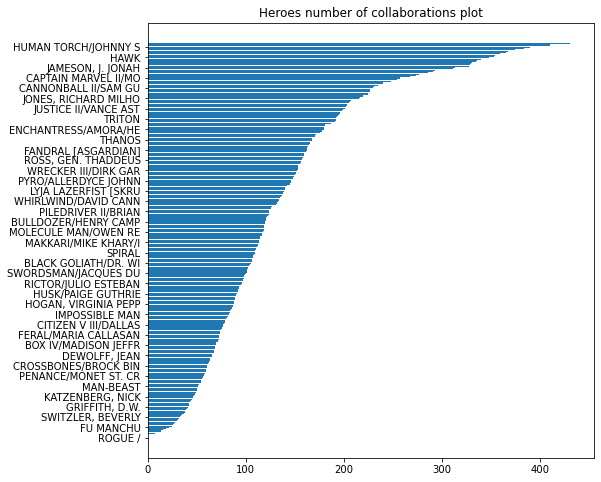

------------------------------
Network degree distro:


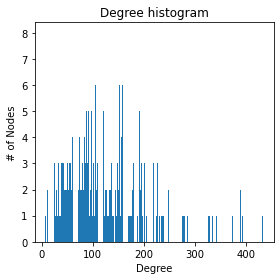

In [53]:
num_nodes, heroes_collab, density, degree_sequence, avg_degree, hubs, isSparse = extract_graph_features(G1, 1, 500)
print("Graph is type 1. Its features are...")
print('⸻' * 25)
print("Number of nodes: ", num_nodes)
print("Network density: ", density)
print("Average degree of the network: ", avg_degree)
print("Network is Sparse?: ", "YES" if isSparse else "NO")
print('---' * 10)
df = pd.DataFrame(hubs, columns=['hub'])
print("Network Hubs: ")
print(df)
print("---" * 10)
names = list(heroes_collab.keys())
values = list(heroes_collab.values())
fig = plt.figure("heroes number of collaborations plot:", figsize=(8, 8))
ax = fig.add_subplot()
ax.barh(names, values, align='center')
ax.set_title("Heroes number of collaborations plot")
ax.set_yticks(ax.get_yticks()[::13])
plt.show()
print("---" * 10)
print("Network degree distro:")
fig = plt.figure("Degree of graph", figsize=(4, 4))
ax = fig.add_subplot()
ax.bar(*np.unique(degree_sequence, return_counts=True))
ax.set_title("Degree histogram")
ax.set_xlabel("Degree")
ax.set_ylabel("# of Nodes")
fig.tight_layout()
plt.show()

Graph is type 2. Its features are...
⸻⸻⸻⸻⸻⸻⸻⸻⸻⸻⸻⸻⸻⸻⸻⸻⸻⸻⸻⸻⸻⸻⸻⸻⸻
Number of hero nodes:  50
Number of comic nodes:  12651
Network density:  0.00034362723004636623
Average degree of the network:  4.36
Network is Sparse?:  YES
------------------------------
Network Hubs: 
Empty DataFrame
Columns: [hub]
Index: []
------------------------------


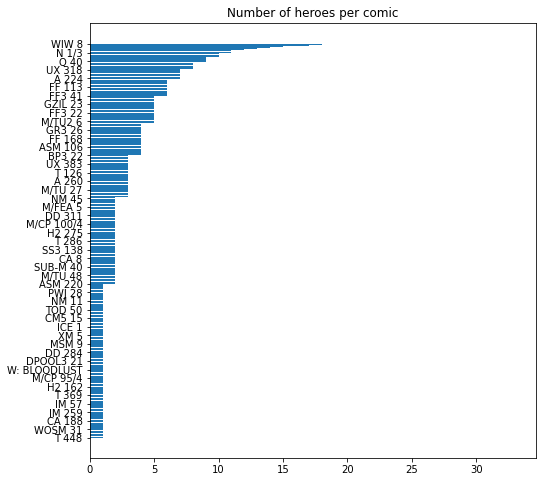

------------------------------
Network degree distro:


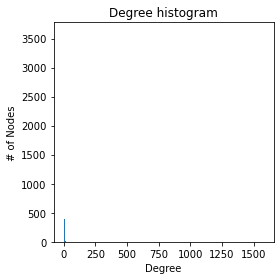

In [61]:
num_nodes_hero, num_nodes_comic, comic_her, density, degree_sequence, avg_degree, hubs, isSparse = extract_graph_features(G2, 2, 50)
print("Graph is type 2. Its features are...")
print('⸻' * 25)
print("Number of hero nodes: ", num_nodes_hero)
print("Number of comic nodes: ", num_nodes_comic)
print("Network density: ", density)
print("Average degree of the network: ", avg_degree)
print("Network is Sparse?: ", "YES" if isSparse else "NO")
print('---' * 10)
df = pd.DataFrame(hubs, columns=['hub'])
print("Network Hubs: ")
print(df)
print("---" * 10)
names = list(comic_her.keys())
values = list(comic_her.values())
fig = plt.figure("number of heroes per comic:", figsize=(8, 8))
ax = fig.add_subplot()
ax.barh(names, values, align='center')
ax.set_title("Number of heroes per comic")
ax.set_yticks(ax.get_yticks()[::200])
plt.show()
print("---" * 10)
print("Network degree distro:")
fig = plt.figure("Degree of graph", figsize=(4, 4))
ax = fig.add_subplot()
ax.bar(*np.unique(degree_sequence, return_counts=True))
ax.set_title("Degree histogram")
ax.set_xlabel("Degree")
ax.set_ylabel("# of Nodes")
fig.tight_layout()
plt.show()

# Visualization 2 - Visualize centrality measure

**We anticipate seeing the Functionality 2 report in Visualization 2. To be more specific, we expect you to have the following report format:**

 - A table containing the information related to the requested centrality measure for:
    - The average of the requested centrality measure for all of the network's nodes
    - The requested centrality measure's value for the given node


# Visualization 3 - Visualize the shortest-ordered route

**We anticipate seeing the Functionality 3 report in Visualization 3. To be more specific, we expect you to have the following report format:**

 - Print the comics in the shortest walk in order
 - Plot the graph and identify the nodes and edges that appear in the shortest walk (please put an identifier on each edge in the shortest walk to determine the order that we should have the walk)


# Visualization 4 - Visualize the disconnected graph

**We anticipate seeing the Functionality 4 report in Visualization 4. To be more specific, we expect you to have the following report format:**

 - Print the number of the links that should be disconnected
 - Plot the original graph
 - Plot the graph after removing the links and identify the two nodes


Truncating path:  SPIDER-MAN/PETER PARKER -- CAPTAIN AMERICA
Truncating path:  SPIDER-MAN/PETER PARKER -- IRON MAN/TONY STARK
Truncating path:  SPIDER-MAN/PETER PARKER -- THOR/DR. DONALD BLAK
Truncating path:  SPIDER-MAN/PETER PARKER -- THING/BENJAMIN J. GR
Truncating path:  SPIDER-MAN/PETER PARKER -- HUMAN TORCH/JOHNNY S
Nodes are disconneted
Minimum edge cut to disconnect  SPIDER-MAN/PETER PARKER  from  CAPTAIN AMERICA : 5


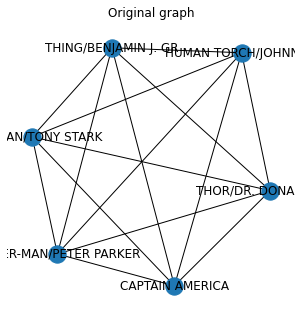

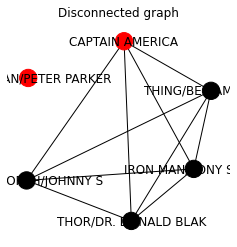

In [89]:
G_copy, G_disc = disconnect_graph(G1, 1, 'SPIDER-MAN/PETER PARKER', 'CAPTAIN AMERICA', 6)
fig = plt.figure(figsize=(4,4))
nx.draw(G_copy, with_labels=True, node_size=300)
plt.title("Original graph")
plt.show()
fig = plt.figure(figsize=(4,4))
plt.title("Disconnected graph")
color_map = []
for node in G_disc.nodes():
    if node in ['SPIDER-MAN/PETER PARKER', 'CAPTAIN AMERICA']:
        color_map.append('red')
    else:
        color_map.append('black')
nx.draw(G_disc, node_color=color_map, with_labels=True)
plt.show()

# Visualization 5 - Visualize the communities

**We anticipate seeing the Functionality 5 report in Visualization 5. To be more specific, we expect you to have the following report format:**

   - Print the number of links that should be removed to have the communities
   - A table depicting the communities and the heroes that belong to each community
   - Plot the original graph
   - Plot the graph showing the communities in the network
   - Plot the final graph and identify the community/communities of Hero_1 and Hero_2

**Notes:**

   - For the final output of your function, please set the Hero_1 to 'Captain America' and Hero_2 to 'Ironman' and show the results
   - If Hero_1 and Hero_2 belong to the same community, identify that community; otherwise, identify those two communities that these heroes belong to.


# 5. Bonus - PageRank on MapReduce

**IMPORTANT: This is a bonus step, so it's not mandatory. You can get the maximum score also without doing this. We will take this into account, only if the rest of the homework has been completed.**

  - PageRank and MapReduce go well together, and this synergy was essential for Google's growth and the MapReduce paradigm's proliferation. Therefore, for the bonus section of this homework, we ask that you implement the PageRank algorithm using the MapReduce paradigm.

**Hint: Here are two approaches to implementing the PageRank algorithm using the MapReduce paradigm that you can use as a reference for your bonus part.**

# 6. Algorithmic Question

**Alex and Sarah have been together for two years, and Alex is now thinking about proposing to her. But, to surprise her, he wants to install an app on her phone that asks her if she will marry him at the right time.**

**However, to install the application secretly, he needs her phone's password, which he does not have. He knows her password is a poly-line made up of vertical or horizontal line segments. In a 3*3 grid, each line segment connects the centres of two cells. Alex learned the direction of each line segment by looking at her hand while unlocking her phone. He didn't pay much attention to the length of each line segment, but he is sure that her phone's operating system does not allow the poly-line to intersect with itself even at one point.**

**Alex wants to distract Sarah's attention long enough to test all possible patterns based on the directions of the line segments he has learned. Therefore, he needs you to assist him in calculating how many possible patterns he has to try based on those directions to estimate how much time he needs to check all of those possibilities. Given that the line segments were directed right, down, left, and up, the following figure depicts two valid and one invalid (as the poly-lines should not intersect even in one point) patterns.**

**Input:**

**The input is a single string that shows the direction of the segment lines and contains only the characters R, L, U, and D, which correspond to the Right, Left, Up, and Down directions. The string's maximum length is 10. It is also guaranteed that two consecutive characters will be different.**

**Ouput:**

**We expect to see only 1 number in the output, corresponding to the number of different patterns that can be generated based on the line segments Alex learned. In some cases, this number may be 0, indicating that no patterns can be generated using the learned line segments.**